# Fixnoise Experiment Notebook

The goal is to get (at least some of) the following experiments running:


5. How can we add less noise in the metacal procedure?

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import tqdm

import autometacal as amc
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_probability as tfp
import galflow as gf
import galsim as gs
import ngmix

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Test setup

In [3]:
#global values
fixnoise = True
batch_size=10
scale= .2
stamp_size = 51
rng = np.random.RandomState(31415)
real_shear = [0.01,0.0]
noise_level = 5e-3

### Data

In [4]:
#dataset
data= tfds.load('GalGen/small_stamp_100k')
data = data['train'].cache()
data = data.batch(batch_size)
data = data.prefetch(tf.data.experimental.AUTOTUNE)
batchit = data.as_numpy_iterator()
onebatch = batchit.next()

In [5]:
#set up jacobian
jacobian = ngmix.DiagonalJacobian(
  row=stamp_size//2, 
  col=stamp_size//2,
  scale=scale,
)
psf_jacobian = ngmix.DiagonalJacobian(
  row=stamp_size//2, 
  col=stamp_size//2,
  scale=scale,
)

# We will measure moments with a fixed gaussian weight function
weight_fwhm = 1.2
fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

# these "runners" run the measurement code on observations
psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
runner = ngmix.runners.Runner(fitter=fitter)

# this "bootstrapper" runs the metacal image shearing as well as both 
# psf and object measurements

types = ['noshear', '1p', '1m','2p','2m']

In [6]:
psf_fwhm=0.7

In [7]:
#create 1 batch of observed images
gal_images=amc.noiseless_real_mcal_image(onebatch['gal_model'],
                                         onebatch['psf_image'],              
                                         tf.repeat([real_shear],len(onebatch['gal_model']),axis=0)
                                                      )

noise = np.random.normal(scale=1e-3,size=[batch_size,51,51])
gal_images += noise
psf_images = onebatch['psf_image']
im = gal_images[0]
psf_im = psf_images[0]

In [8]:
step = .5
g = [[step,0.]]
reconv_psf = gf.dilate(psf_images[0][tf.newaxis,...,tf.newaxis],1+2*abs(step))[...,0]
mcalimg = amc.generate_mcal_image(gal_images[0][tf.newaxis], 
                                  psf_images[0][tf.newaxis],
                                  reconv_psf,
                                  g,
                                  padfactor=3)

def generate_fixnoise(noise,psf_image,reconvolution_psf_image,g):
  
  shearednoise = amc.generate_mcal_image(noise,
                                   psf_image,
                                   reconvolution_psf_image,g )
  rotshearednoise = tf.image.rot90(shearednoise[...,tf.newaxis],k=-1)[...,0]
  return rotshearednoise

input_data = gal_images[0]
fixnoise_level = 1.4*tfp.stats.percentile(tf.math.abs(input_data - tfp.stats.percentile(input_data,50)),50)
noise = tf.random.normal([1,51,51],0,fixnoise_level)
fixnoise_img = generate_fixnoise(noise,psf_images[0][tf.newaxis],reconv_psf,g)

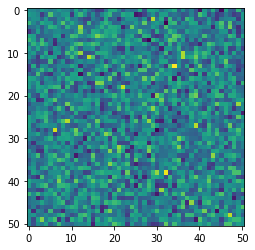

In [9]:
imshow(noise[0])

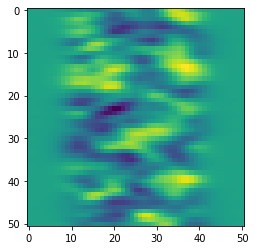

In [10]:
imshow(fixnoise_img[0])

In [11]:
boot = ngmix.metacal.MetacalBootstrapper(
  runner=runner, psf_runner=psf_runner,
  rng=rng,
  psf='gauss',
  types=types,
  fixnoise=fixnoise,
  step=step
)

wt = tf.reduce_mean(1.0/(noise)**2,axis=0)
psf_wt = tf.reduce_mean(1.0/(noise/100)**2,axis=0)

psf_obs = ngmix.Observation(
  psf_im,
  weight=psf_wt,
  jacobian=psf_jacobian,
)
obs = ngmix.Observation(
  im,
  jacobian=jacobian,
  weight=wt,
  psf=psf_obs,
)

resdict, obsdict = boot.go(obs)

In [12]:
fixnoised = mcalimg[0] + fixnoise_img[0]

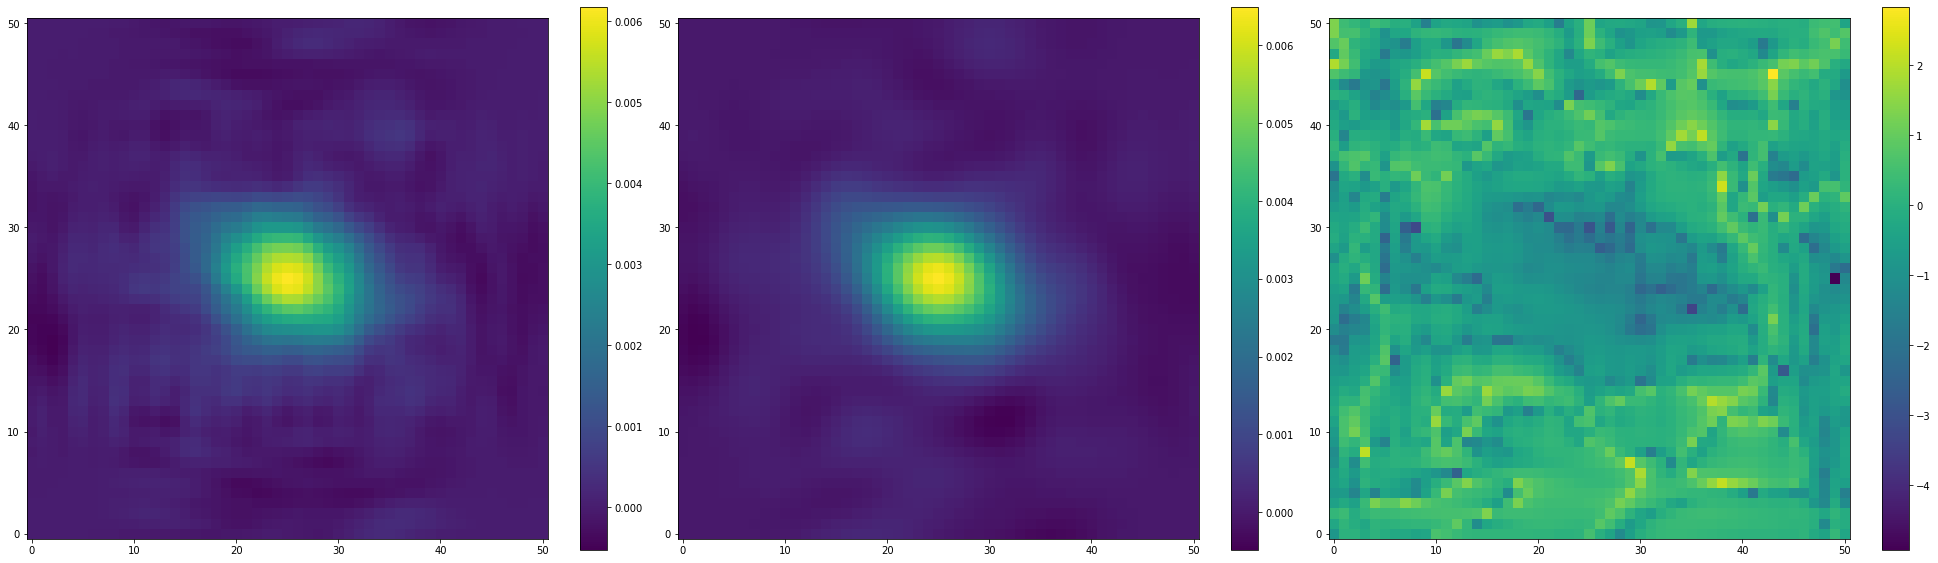

In [13]:
figure(figsize=(35,10))
subplot(131)
imshow(fixnoised,origin='lower');colorbar()
subplot(132)
imshow(obsdict['1p'].image,origin='lower');colorbar()
subplot(133)
imshow(log10(abs(obsdict['1p'].image - fixnoised)/abs(obsdict['1p'].image)),origin='lower');colorbar()
subplots_adjust(wspace=0,hspace=0)

In [14]:
banana();

NameError: name 'banana' is not defined

Display a range of galaxy models:

In [ ]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()
gal_images = onebatch['gal_model'] 
labels = onebatch['label'] 
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i],origin='lower')
  title(f"e1= {labels[i][0]:.4f},e2={labels[i][1]:.4f}",fontsize=10)
  axis('off')

We transform these models by:
1. Adding a constant shear
3. Convolving with a PSF
2. Adding some noise

Both 1 and 2 are taken care by the noiseless_real_mcal_image function developed for the LearnR project.

In [ ]:
#create 1 batch of observed images
gal_images=amc.noiseless_real_mcal_image(onebatch['gal_model'],onebatch['psf_image'],
                          tf.repeat([real_shear],len(onebatch['gal_model']),axis=0))

noise = np.random.normal(scale=noise_level,size=[batch_size,51,51])
gal_images += noise
psf_images = onebatch['psf_image']

In [ ]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i],origin= 'lower')
  title(f"e1= {labels[i][0]:.4f},e2={labels[i][1]:.4f}",fontsize=10)
  axis('off')

## Set up ngmix

In [ ]:
#set up jacobian
jacobian = ngmix.DiagonalJacobian(
  row=stamp_size//2, 
  col=stamp_size//2,
  scale=scale,
)
psf_jacobian = ngmix.DiagonalJacobian(
  row=stamp_size//2, 
  col=stamp_size//2,
  scale=scale,
)

In [ ]:
# We will measure moments with a fixed gaussian weight function
weight_fwhm = 1.2
fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

# these "runners" run the measurement code on observations
psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
runner = ngmix.runners.Runner(fitter=fitter)

# this "bootstrapper" runs the metacal image shearing as well as both 
# psf and object measurements

types = ['noshear', '1p', '1m','2p','2m']
boot = ngmix.metacal.MetacalBootstrapper(
  runner=runner, psf_runner=psf_runner,
  rng=rng,
  psf='gauss',
  types=types,
  fixnoise=fixnoise,
)

Set up functions to get responses from AMC and ngmix

In [ ]:
#for ngmix
def get_metacal_response_ngmix(resdict):
  step=0.01

  e1, e2 = resdict['noshear']['e1'], resdict['noshear']['e2']
 
  g0s = np.array([resdict['noshear']['e1'], resdict['noshear']['e2']])
  g1p = np.array([resdict['1p']['e1'], resdict['1p']['e2']])
  g1m = np.array([resdict['1m']['e1'], resdict['1m']['e2']])
  g2p = np.array([resdict['2p']['e1'], resdict['2p']['e2']])
  g2m = np.array([resdict['2m']['e1'], resdict['2m']['e2']])    
  
  R11 = (g1p[0]-g1m[0])/(2*step)
  R21 = (g1p[1]-g1m[1])/(2*step) 
  R12 = (g2p[0]-g2m[0])/(2*step)
  R22 = (g2p[1]-g2m[1])/(2*step)  
   
  ellip_dict = {
    'noshear':g0s,
    '1p':g1p,
    '1m':g1m,
    '2p':g2p,
    '2m':g2m,    
  } 
  
  R = np.array(
    [[R11,R12],
     [R21,R22]])
    
  return ellip_dict, R 

#AutoMetaCal runner
method = lambda im: amc.get_moment_ellipticities(im, scale=0.2, fwhm=1.2)

#for amc
@tf.function
def response(gal_images,psf_images):
  return amc.get_metacal_response(gal_images, psf_images,psf_images,method)

## Shakedown Test!

Let's make a measurement on a single image.

In [ ]:
im = gal_images[0]
psf_im = psf_images[0] 

In [ ]:
wt = tf.reduce_mean(1.0/(noise)**2,axis=0)
psf_wt = tf.reduce_mean(1.0/(noise/100)**2,axis=0)

psf_obs = ngmix.Observation(
  psf_im,
  weight=psf_wt,
  jacobian=psf_jacobian,
)
obs = ngmix.Observation(
  im,
  jacobian=jacobian,
  weight=wt,
  psf=psf_obs,
)

Run one ngmix measurement:

In [ ]:
resdict, obsdict = boot.go(obs)

In [ ]:
true = labels[0]

#ngmix calibration
ellips, R_ngmix = get_metacal_response_ngmix(resdict)
calibrated_ngmix = linalg.inv(R_ngmix) @ ellips['noshear']

e_amc, R_auto = response(im[tf.newaxis], psf_im[tf.newaxis])
calibrated_amc = linalg.inv(R_auto[0].numpy()) @ e_amc[0].numpy()

In [ ]:
print("True:")
print(f"e1={true[0]:.6f}, e2={true[1]:.6f}.")

print("\nngmix:")
print(f"e1={calibrated_ngmix[0]:.6f}, e2={calibrated_ngmix[1]:.6f}.")

print("\nAutoMetaCal")
print(f"e1={calibrated_amc[0]:.6f}, e2={calibrated_amc[1]:.6f}.")

Different Reconvolution PSFs if needed

## One Batch Test

In [ ]:
#reset data
batchit = data.as_numpy_iterator()
onebatch = batchit.next()

In [ ]:
#get response and noshear ellipticities
e_amc, R_auto = response(gal_images, psf_images)
e_amc=tf.concat([e_amc],axis=0)
R_auto=tf.concat([R_auto],axis=0)

#averaging procedure
uncalibrated_shear_amc = tf.reduce_mean(e_amc,axis=0)
calibrated_shear_amc = tf.linalg.inv(tf.reduce_mean(R_auto[:],axis=0)) @ tf.reduce_mean(tf.reshape(e_amc,[-1,2,1]),axis=0)
calibrated_shear_amc_err = tf.linalg.inv(tf.reduce_mean(R_auto[:],axis=0)) @ tf.math.reduce_std(tf.reshape(e_amc,[-1,2,1]),axis=0)/sqrt(batch_size)

Testing AMC speed: 

In [ ]:
%%timeit
e_amc_batch, R_auto_batch = response(gal_images, psf_images)

To be fair, let's use ngmix in parallel. 

In [ ]:
#parallelisable function to map the data to
def response_ngmix(im_psf):
  im, psf = im_psf
  
  psf_obs = ngmix.Observation(
    psf_im,
    weight=psf_wt,
    jacobian=psf_jacobian,
  )
  obs = ngmix.Observation(
    im,
    jacobian=jacobian,
    weight=wt,
    psf=psf_obs,
  )
  
  #get moment ellipticities
  resdict, obsdict = boot.go(obs)
  e_ngmix, R_ngmix = get_metacal_response_ngmix(resdict)
  
  return e_ngmix['noshear'], R_ngmix

In [ ]:
from multiprocessing import Pool, freeze_support, cpu_count
pool = Pool(cpu_count()) 

In [ ]:
gal_imlist = [gal_images.numpy()[i] for i in range(len(gal_images))]
psf_imlist = [psf_images[i] for i in range(len(gal_images))]
ims_psfs = zip(gal_imlist,psf_imlist)

Testing ngmix speed:

In [ ]:
t = time.time()
results = pool.map(response_ngmix, ims_psfs)
print(f"Finished in: {time.time()-t} s.")

In [ ]:
pool.close()

In [ ]:
e_ngmix_list = [result[0] for result in results]
R_ngmix_list = [result[1] for result in results]

In [ ]:
calibrated_shear_ngmix = linalg.inv(mean(array(R_ngmix_list),axis=0)) @ mean(array(e_ngmix_list),axis=0)
calibrated_shear_ngmix_err = linalg.inv(mean(array(R_ngmix_list),axis=0)) @ std(array(e_ngmix_list),axis=0)/sqrt(batch_size)

In [ ]:
print("True:")
print(f"e1={real_shear[0]:.6f}, e2={real_shear[1]:.6f}.")

print("\nUncalibrated shear estimation over 1k")
print(f"e1={uncalibrated_shear_amc[0]:.6f}, e2={uncalibrated_shear_amc[1]:.6f}.")

print("\nAutoMetaCal shear estimation over 1k")
print(f"e1={calibrated_shear_amc[0,0]:.6f}, e2={calibrated_shear_amc[1,0]:.6f}.")

print("\nngmix shear estimation over 1k")
print(f"e1={calibrated_shear_ngmix[0]:.6f}, e2={calibrated_shear_ngmix[1]:.6f}.")

In [ ]:
m1_amc =  calibrated_shear_amc[0,0]/real_shear[0] - 1 
m1_amc_err =  calibrated_shear_amc_err[0,0]/real_shear[0]
print("Autometacal:")
print(f"m_1 = {m1_amc: .6f} +/- {m1_amc_err: .6f}")

m1_ngmix =  calibrated_shear_ngmix[0]/real_shear[0] -1 
m1_ngmix_err =  calibrated_shear_ngmix_err[0]/real_shear[0] 
print("\nngmix:")
print(f"m_1 = {m1_ngmix: .6f} +/- {m1_ngmix_err: .6f}")

## All Batches Test

In [ ]:
#reset data
batchit = data.as_numpy_iterator()

In [ ]:
e_amc = []
R_auto = []
e_ngmix_list = []
R_ngmix_list = []

for _ in tqdm.tqdm(range(100)):
  onebatch = batchit.next()
  
  #prepare batch
  gal_images=amc.noiseless_real_mcal_image(onebatch['gal_model'],onebatch['psf_image'],
                            tf.repeat([real_shear],len(onebatch['gal_model']),axis=0))

  noise = np.random.normal(scale=noise_level,size=[len(gal_images),51,51])
  
  gal_images += noise
  psf_images = onebatch['psf_image']

  #run amc
  e_amc_batch, R_auto_batch = response(gal_images, psf_images)
  #gather amc results
  e_amc.append(e_amc_batch)
  R_auto.append(R_auto_batch)
  
  #prepare list for parallel map
  gal_imlist = [gal_images.numpy()[i] for i in range(len(gal_images))]
  psf_imlist = [psf_images[i] for i in range(len(gal_images))]
  ims_psfs = zip(gal_imlist,psf_imlist)
  
  #start and run parallel pool
  pool = Pool(cpu_count()//2)
  results = pool.map(response_ngmix, ims_psfs)
  pool.close()
  
  #append ngmix results
  e_ngmix_list += [result[0] for result in results]
  R_ngmix_list += [result[1] for result in results]
  
e_amc=tf.concat(e_amc,axis=0)
R_auto=tf.concat(R_auto,axis=0)

In [ ]:
#averaging amc results
uncalibrated_shear_amc = tf.reduce_mean(e_amc,axis=0)
calibrated_shear_amc = tf.linalg.inv(tf.reduce_mean(R_auto[:],axis=0)) @ tf.reduce_mean(tf.reshape(e_amc,[-1,2,1]),axis=0)
calibrated_shear_amc_err = tf.linalg.inv(tf.reduce_mean(R_auto[:],axis=0)) @ tf.math.reduce_std(tf.reshape(e_amc,[-1,2,1]),axis=0)/sqrt(batch_size*100)

#averaging ngmix results
calibrated_shear_ngmix = linalg.inv(mean(array(R_ngmix_list),axis=0)) @ mean(array(e_ngmix_list),axis=0)
calibrated_shear_ngmix_err = linalg.inv(mean(array(R_ngmix_list),axis=0)) @ std(array(e_ngmix_list),axis=0)/sqrt(batch_size*100)

In [ ]:
m1_amc =  calibrated_shear_amc[0,0]/real_shear[0] -1 
m1_amc_err = calibrated_shear_amc_err[0,0]/real_shear[0]

print("Autometacal:")
print(f"m_1 = {m1_amc: .6f} +/- {m1_amc_err: .6f}")

m1_ngmix =  calibrated_shear_ngmix[0]/real_shear[0] -1 
m1_ngmix_err = calibrated_shear_ngmix_err[0]/real_shear[0]

print("\nngmix:")
print(f"m_1 = {m1_ngmix: .6f} +/- {m1_ngmix_err: .6f}")

## Fixnoise

In [ ]:
#create 1 batch of observed images
gal_images=amc.noiseless_real_mcal_image(onebatch['gal_model'],onebatch['psf_image'],
                          tf.repeat([real_shear],len(onebatch['gal_model']),axis=0))

noise = np.random.normal(scale=1e-3,size=[batch_size,51,51])
gal_images += noise
psf_images = onebatch['psf_image']

#for amc
@tf.function
def response(gal_images,psf_images):
  return amc.get_metacal_response(gal_images, psf_images,psf_images,method,fixnoise=True)



def mad(input_data):
    r"""Median absolute deviation.
    This method calculates the median absolute deviation of the input data.
    Parameters
    ----------
    input_data : numpy.ndarray
        Input data array
    Returns
    -------
    float
        MAD value
    Examples
    --------
    >>> import numpy as np
    >>> from modopt.math.stats import mad
    >>> a = np.arange(9).reshape(3, 3)
    >>> mad(a)
    2.0
    Notes
    -----
    The MAD is calculated as follows:
    .. math::
        \mathrm{MAD} = \mathrm{median}\left(|X_i - \mathrm{median}(X)|\right)
    See Also
    --------
    numpy.median : median function used
    """
    return tfp.stats.median(tf.math.abs(input_data - tfp.stats.median(input_data)))

def sigma_mad(input_data):
    r"""MAD Standard Deviation.
    This method calculates the standard deviation of the input data from the
    MAD.
    Parameters
    ----------
    input_data : numpy.ndarray
        Input data array
    Returns
    -------
    float
        Sigma value
    Examples
    --------
    >>> import numpy as np
    >>> from modopt.math.stats import sigma_mad
    >>> a = np.arange(9).reshape(3, 3)
    >>> sigma_mad(a)
    2.9652
    Notes
    -----
    This function can be used for estimating the standeviation of the noise in
    imgaes.
    Sigma is calculated as follows:
    .. math::
        \sigma = 1.4826 \mathrm{MAD}(X)
    """
    return 1.4826 * mad(input_data)






In [ ]:
import tensorflow_probability as tfp

In [ ]:
input_data = gal_images[0]


In [ ]:
fixnoise_img=generate_fixnoise([1,51,51,1], psf_images[0][tf.newaxis],psf_images[0][tf.newaxis],[[0.3,0.]],std=sigma_mad(gal_images[0]))

In [ ]:
imshow(mcalimg[0]+fixnoise_img[0,...,0])